# 1. imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 2. implementation

## 2.1. Metrics

In [2]:
class Metrics:        
    @staticmethod
    def from_name(p_name):
        match p_name:
            case "MSE":
                return Metrics.MSE
            case "F-score":
                return Metrics.F_score
            case _:
                print("Warning: Unknown metric name. Using MSE instead")
                return Metrics.MSE
    
    @staticmethod
    def MSE(p_y_true, p_y_pred):
        return np.mean((p_y_pred - p_y_true) ** 2)

    @staticmethod
    def F_score(p_y_true, p_y_pred):
        unique_classes = np.unique(p_y_true)

        precision_list = []
        recall_list = []
        fscore_list = []

        for klass in unique_classes:
            true_positives = np.sum((p_y_pred == klass) & (p_y_true == klass))
            false_positives = np.sum((p_y_pred == klass) & (p_y_true != klass))
            false_negatives = np.sum((p_y_pred != klass) & (p_y_true == klass))

            precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
            fscore = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

            precision_list.append(precision)
            recall_list.append(recall)
            fscore_list.append(fscore)

        precision2 = np.mean(precision_list)
        recall2 = np.mean(recall_list)
        fscore2 = np.mean(fscore_list)

        # return precision2, recall2, fscore2
        return fscore2

## 2.2. Cost functions

In [3]:
class Cost:        
    @staticmethod
    def from_name(p_name):
        match p_name:
            case "cross-entropy":
                return Cost.cross_entropy, Cost.cross_entropy_der
            case "MSE":
                return Cost.MSE, Cost.MSE_der
            case _:
                print("Warning: Unknown cost function type. Using MSE instead.")
                return Cost.MSE, Cost.MSE_der
            
    @staticmethod
    def cross_entropy(y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred))
    
    @staticmethod
    def cross_entropy_der(y_true, y_pred):
        return -1 / len(y_pred) * (y_true / y_pred)
    
    @staticmethod
    def MSE(y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)
    
    @staticmethod
    def MSE_der(y_true, y_pred):
        return 2 / len(y_pred) * (y_pred - y_true)

## 2.3. Activation functions

In [4]:
class Activation:
    @staticmethod
    def from_name(p_name):
        match p_name:
            case "linear":
                return Activation.linear, Activation.linear_der
            case "sigmoid":
                return Activation.sigmoid, Activation.sigmoid_der
            case "softmax":
                return Activation.softmax, Activation.softmax_der
            case _:
                print("Warning: Unknown activation function type. Using Sigmoid instead.")
                return Activation.sigmoid, Activation.sigmoid_der
    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_der(x):
        return np.identity(n=len(x))
            
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_der(x):
        a = Activation.sigmoid(x)
        return a * (1 - a)
    
    @staticmethod
    def softmax(x):
        n = np.exp(x)
        d = np.sum(n, axis=1, keepdims=True)
        return n / d

    @staticmethod
    def softmax_der(x):
        a = Activation.softmax(x)
        res = -a.T @ a
        np.fill_diagonal(res, a * (1 - a))
        return res

## 2.4. Layer

In [5]:
class Layer:
    def __init__(self, p_in, p_out, p_act, p_w_init):
        n = p_in + p_out
        w_shape = (p_in, p_out)
        b_shape = (1, p_out)
        
        self.x = 0
        self.z = 0
        
        match p_w_init:
            case "unif":
                self.weights = np.random.uniform(0, 1, size=w_shape)
            case "Xavier":
                a = np.sqrt(6 / n)
                self.weights = np.random.uniform(-a, a, size=w_shape)
            case "He":
                self.weights = np.random.normal(0, np.sqrt(2 / n), size=w_shape)
        self.biases = np.zeros(shape=b_shape)
        self.weights_grad = np.zeros(shape=w_shape)
        self.biases_grad = np.zeros(shape=b_shape)
        self.weights_Momentum = np.zeros(shape=w_shape)
        self.biases_Momentum = np.zeros(shape=b_shape)
        self.weights_RMSProp = np.zeros(shape=w_shape)
        self.biases_RMSProp = np.zeros(shape=b_shape)
        
        self.act, self.act_der = Activation.from_name(p_act)
        
        return
    
    def forward(self, p_input):
        self.x = p_input
        self.z = np.dot(self.x, self.weights) + self.biases
        
        return self.act(self.z)

## 2.5. Network

In [6]:
class Network:
    def __init__(self, p_layers, p_act, p_out_act, p_w_init):
        self.L = len(p_layers) - 1
        self.layers = []
        
        self.mean_x = 0
        self.std_x = 1       
        self.mean_y = 0
        self.std_y = 1
        
        for l in range(self.L - 1):
            self.layers.append(Layer(p_layers[l], p_layers[l + 1], p_act, p_w_init))
        self.layers.append(Layer(p_layers[-2], p_layers[-1], p_out_act, p_w_init))
        
        return
    
    def set_normals(self, p_x, p_y):
        self.mean_x = p_x.mean()
        self.std_x = p_x.std()
        self.mean_y = p_y.mean()
        self.std_y = p_y.std()
        
        return
    
    def normalise(self, p_x):
        return (p_x - self.mean_x) / self.std_x
    
    def denormalise(self, p_y):
        return p_y * self.std_y + self.mean_y
    
    def predict(self, p_input):
        result = self.normalise(p_input)
        
        for layer in self.layers:
            result = layer.forward(result)
            
        return result
        # return self.denormalise(result)
    
    def train(self, p_x, p_y, p_epochs, p_lr, p_mb_size, p_shuffle, p_method, p_beta, p_cost):
        n = len(p_x)
        
        if type(p_mb_size) == float and 0 < p_mb_size < 1:
            p_mb_size = int(p_mb_size * n)
            
        self.set_normals(p_x, p_y)
        
        cost = Metrics.from_name(p_cost)
        costs = []
        
        for e in range(p_epochs):
            indexes = list(range(n))
            
            if p_shuffle:
                np.random.shuffle(indexes)
                
            for k in range(0, n, p_mb_size):
                mb_indexes = indexes[k:k + p_mb_size]
                
                y_pred = self.predict(p_x[mb_indexes])
                
                delta = (y_pred - p_y[mb_indexes])
                for l in reversed(range(1, self.L)):
                    self.layers[l].weights_grad = np.dot(self.layers[l].x.T, delta)
                    self.layers[l].biases_grad = np.sum(delta, axis = 0)
                    delta = np.dot(delta, self.layers[l].weights.T) * self.layers[l - 1].act_der(self.layers[l - 1].z)
                self.layers[0].weights_grad = np.dot(self.layers[0].x.T, delta)
                self.layers[0].biases_grad = np.sum(delta, axis = 0)
        
                match p_method:
                    case "Momentum":
                        self.use_momentum(p_beta)
                    case "RMSProp":
                        self.use_RMSProp(p_beta)
                
                for layer in self.layers:
                    layer.weights -= p_lr / len(mb_indexes) * layer.weights_grad 
                    layer.biases -= p_lr / len(mb_indexes) * layer.biases_grad 
            
            costs.append(cost(p_y, self.predict(p_x)))
        
        return costs
    
    def use_momentum(self, p_beta):
        for layer in self.layers:
            layer.weights_Momentum = layer.weights_grad + layer.weights_Momentum * p_beta
            layer.biases_Momentum = layer.biases_grad + layer.biases_Momentum * p_beta
            
            layer.weights_grad = layer.weights_Momentum
            layer.biases_grad = layer.biases_Momentum
        
        return
    
    def use_RMSProp(self, p_beta):
        for layer in self.layers:
            layer.weights_RMSProp = p_beta * layer.weights_RMSProp + (1 - p_beta) * np.square(layer.weights_grad)
            layer.biases_RMSProp = p_beta * layer.biases_RMSProp + (1 - p_beta) * np.square(layer.biases_grad)
            
            layer.weights_grad = np.divide(layer.weights_grad, np.sqrt(layer.weights_RMSProp) + 0.000001)
            layer.biases_grad = np.divide(layer.biases_grad, np.sqrt(layer.biases_RMSProp) + 0.000001)

        return

## 2.6. one-hot encoding

In [7]:
def one_hot(categories):
    unique_categories = np.unique(categories)
    one_hot_encoding = np.zeros((len(categories), len(unique_categories)), dtype=int)

    for i, category in enumerate(categories):
        index = np.where(unique_categories == category)[0][0]
        one_hot_encoding[i, index] = 1

    return(one_hot_encoding)

# 3. testing model

## 3.0. helpful functions

In [8]:
def present(layers, x, y, epochs, lr, mb_size, shuffle):
    network_SoftMax = Network(layers, "sigmoid", "softmax", "He")
    SoftMax_costs = network_SoftMax.train(x, y, epochs, lr, mb_size, shuffle, "Momentum", 0.9, "F-score")
    
    network_Sigmoid = Network(layers, "sigmoid", "sigmoid", "He")
    Sigmoid_costs = network_Sigmoid.train(x, y, epochs, lr, mb_size, shuffle, "Momentum", 0.9, "F-score")
    
    plt.plot(range(epochs), SoftMax_costs)
    plt.plot(range(epochs), Sigmoid_costs)
    plt.legend(['SoftMax', 'Sigmoid'])
    plt.show()
    
    print(f"SoftMax last cost = {SoftMax_costs[-1]}")
    print(f"Sigmoid last cost = {Sigmoid_costs[-1]}")
    
    return network_SoftMax, network_Sigmoid

In [9]:
def plot_predict(model, X_train, y_train, X_test, y_test):
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1)

    print(f"train F-score = {Metrics.F_score(y_train, y_train_pred)}")
    print(f"test F-score  = {Metrics.F_score(y_test, y_test_pred)}")

    plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
    plt.title('train true')
    plt.show()
    
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train_pred)
    plt.title('train predicted')
    plt.show()

    plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
    plt.title('test true')
    plt.show()
    
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred)
    plt.title('test predicted')
    plt.show()

## 3.1. easy

In [10]:
easy_train = pd.read_csv('../data/classification/easy-training.csv')
easy_test = pd.read_csv('../data/classification/easy-test.csv')

In [11]:
easy_X_train = easy_train.drop(columns='c')
easy_y_train = easy_train['c']

easy_X_test = easy_test.drop(columns='c')
easy_y_test = easy_test['c']

es_X_train = easy_X_train.to_numpy().reshape(easy_X_train.shape)
es_y_train = easy_y_train.to_numpy().reshape((easy_y_train.shape[0], 1))

es_X_test = easy_X_test.to_numpy().reshape(easy_X_test.shape)
es_y_test = easy_y_test.to_numpy().reshape((easy_y_test.shape[0], 1))

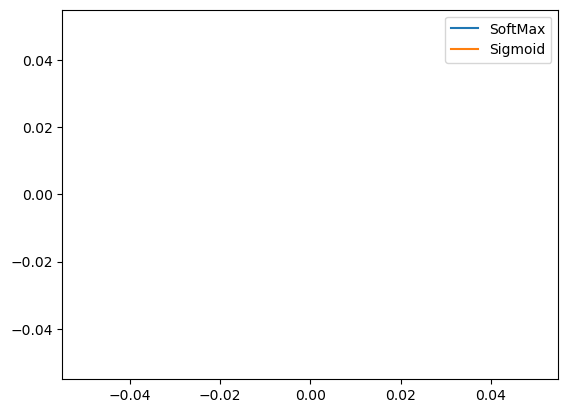

SoftMax last cost = 0.0
Sigmoid last cost = 0.0


In [12]:
network_SoftMax, network_Sigmoid = present([2, 5, 2], es_X_train, one_hot(es_y_train), 1, 0.01, 0.1, True)

train F-score = 0.36580416032470825
test F-score  = 0.34692734823386684


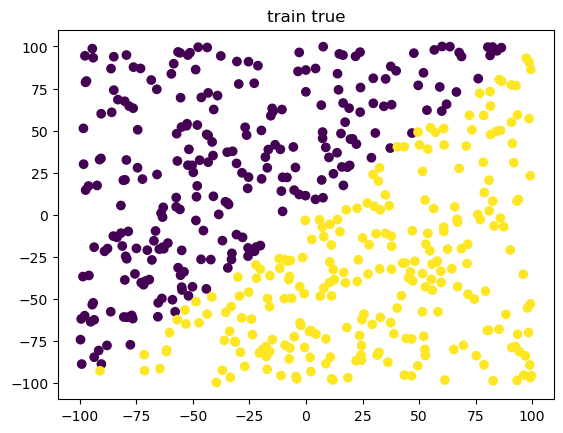

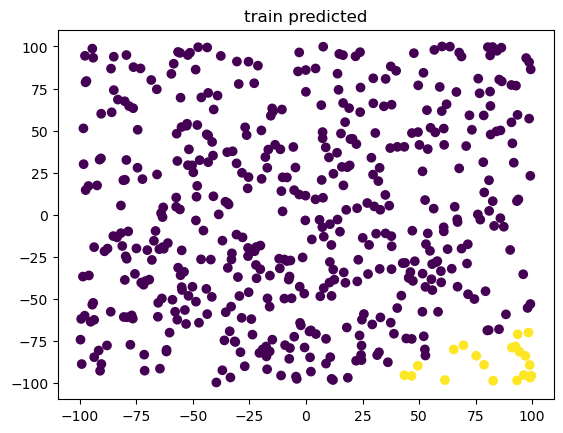

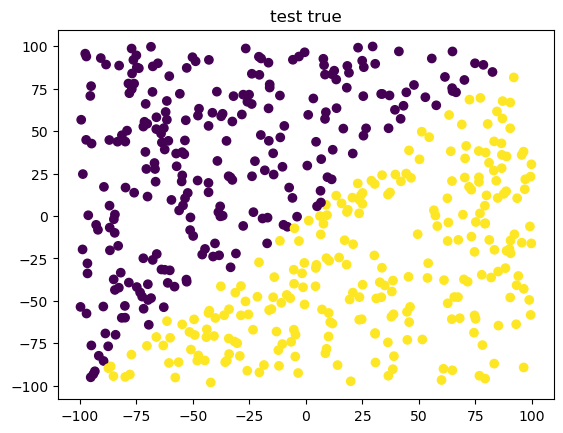

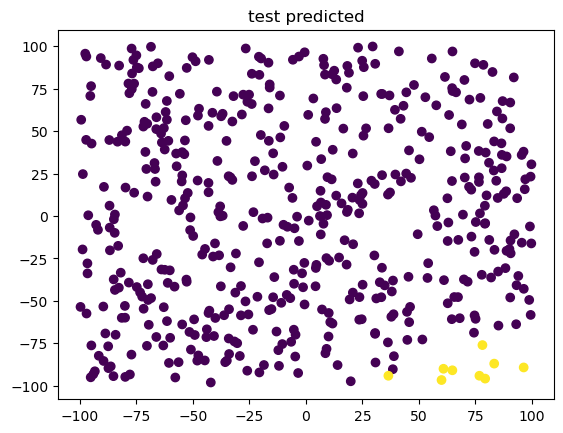

In [13]:
plot_predict(network_SoftMax, es_X_train, es_y_train, es_X_test, es_y_test)

train F-score = 0.45613393898257887
test F-score  = 0.46112679471414464


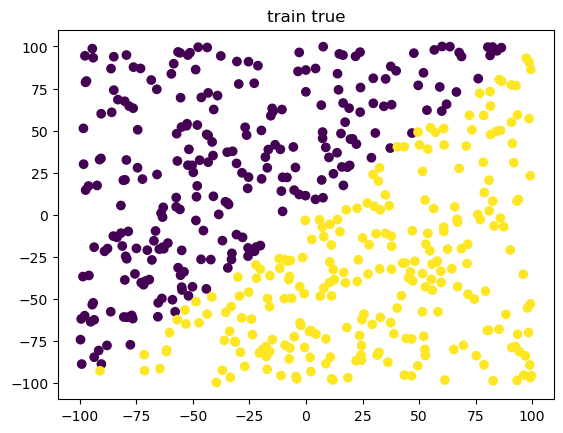

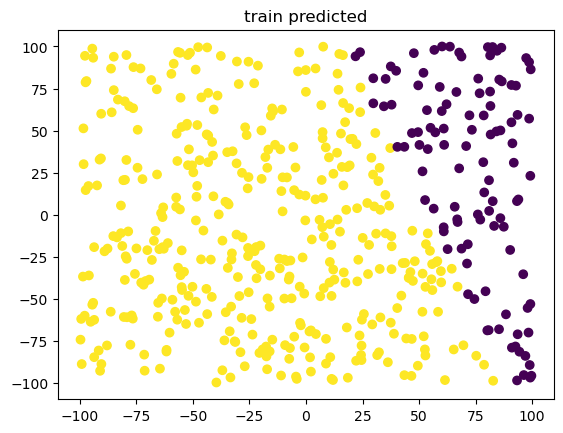

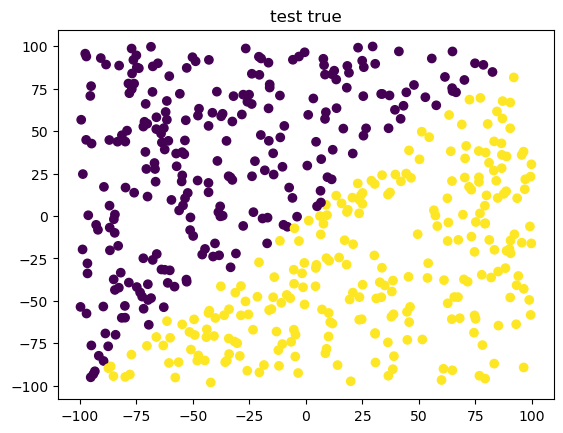

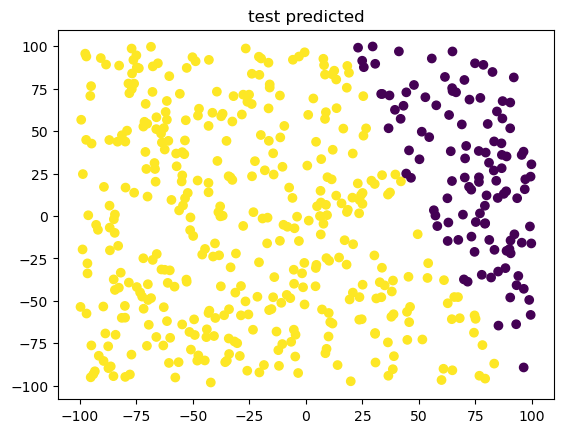

In [14]:
plot_predict(network_Sigmoid, es_X_train, es_y_train, es_X_test, es_y_test)

## 3.2. rings

In [15]:
rings_train = pd.read_csv('../data/classification/rings3-regular-training.csv')
rings_test = pd.read_csv('../data/classification/rings3-regular-test.csv')

In [16]:
rings_X_train = rings_train.drop(columns='c')
rings_y_train = rings_train['c']

rings_X_test = rings_test.drop(columns='c')
rings_y_test = rings_test['c']

rng_X_train = rings_X_train.to_numpy().reshape(rings_X_train.shape)
rng_y_train = rings_y_train.to_numpy().reshape((rings_y_train.shape[0], 1))

rng_X_test = rings_X_test.to_numpy().reshape(rings_X_test.shape)
rng_y_test = rings_y_test.to_numpy().reshape((rings_y_test.shape[0], 1))

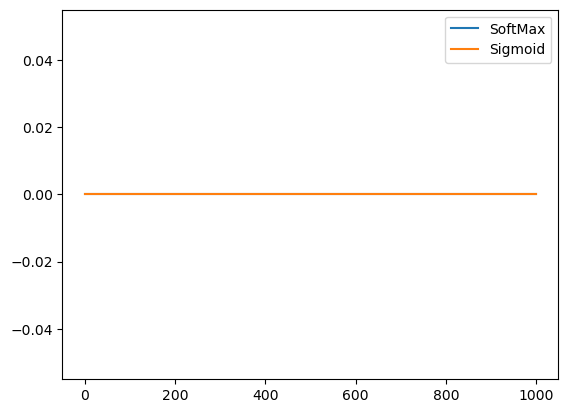

SoftMax last cost = 0.0
Sigmoid last cost = 0.0


In [17]:
network_SoftMax, network_Sigmoid = present([2, 12, 12, 3], rng_X_train, one_hot(rng_y_train), 1000, 0.001, 100, True)

train F-score = 0.31300301275653303
test F-score  = 0.29950263156028617


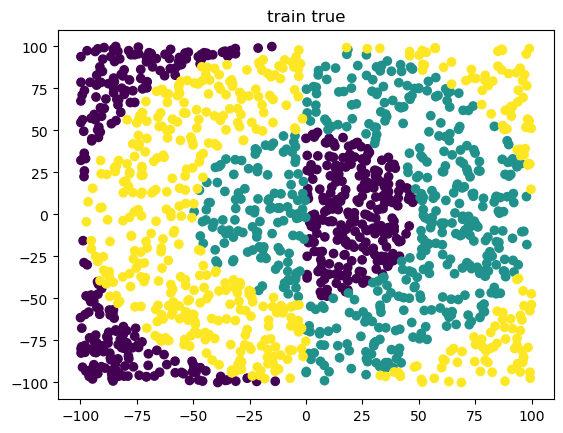

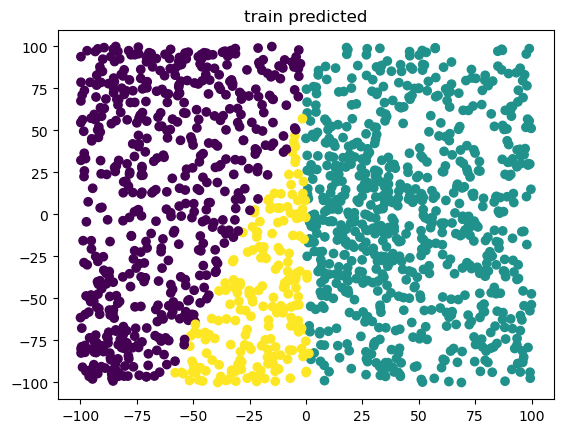

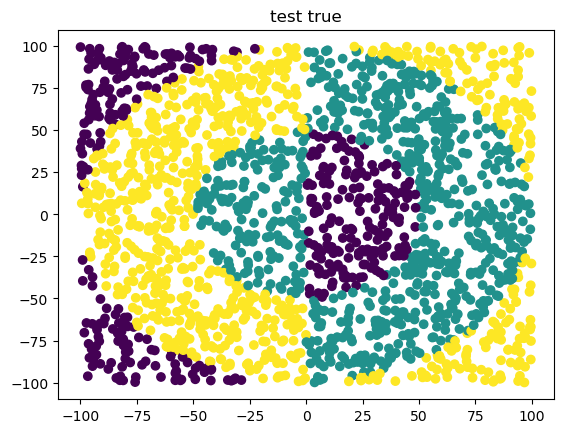

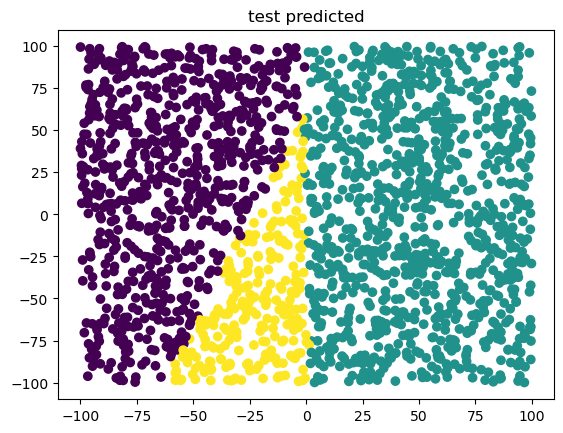

In [18]:
plot_predict(network_SoftMax, rng_X_train, rng_y_train, rng_X_test, rng_y_test)

train F-score = 0.2854332609815099
test F-score  = 0.2618193266529453


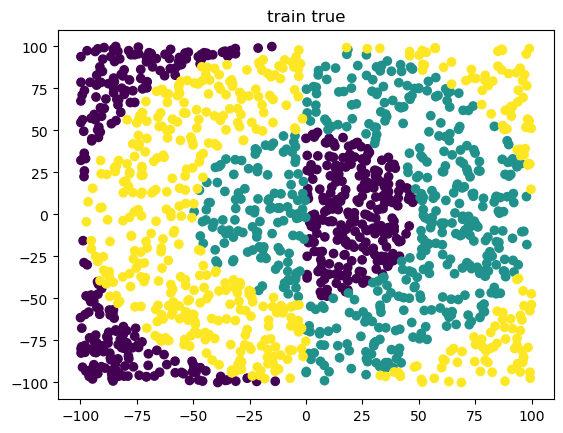

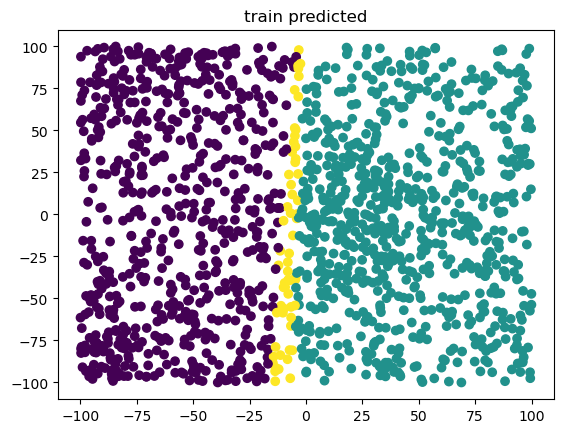

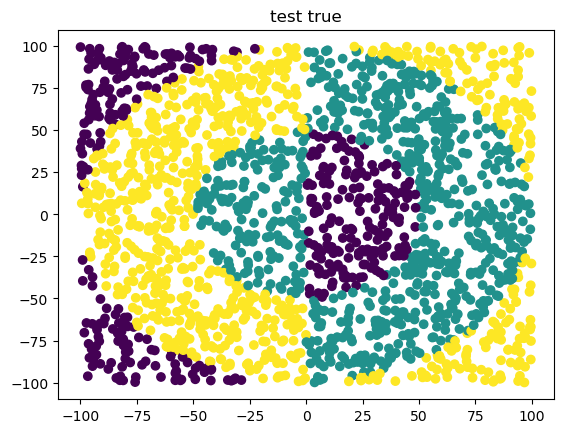

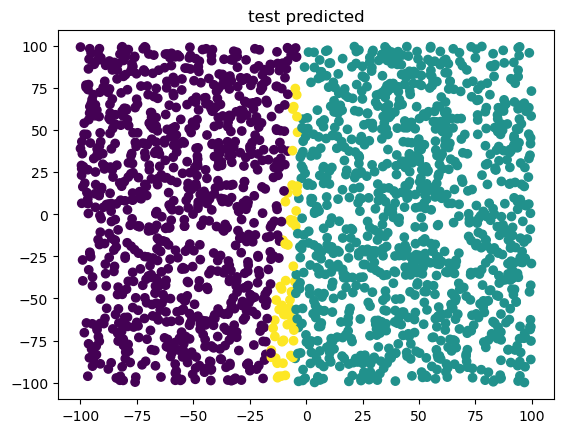

In [19]:
plot_predict(network_Sigmoid, rng_X_train, rng_y_train, rng_X_test, rng_y_test)

## 3.3. xor

In [20]:
xor_train = pd.read_csv('../data/classification/xor3-training.csv')
xor_test = pd.read_csv('../data/classification/xor3-test.csv')

In [21]:
xor_X_train = xor_train.drop(columns='c')
xor_y_train = xor_train['c']

xor_X_test = xor_test.drop(columns='c')
xor_y_test = xor_test['c']

x_X_train = xor_X_train.to_numpy().reshape(xor_X_train.shape)
x_y_train = xor_y_train.to_numpy().reshape((xor_y_train.shape[0], 1))

x_X_test = xor_X_test.to_numpy().reshape(xor_X_test.shape)
x_y_test = xor_y_test.to_numpy().reshape((xor_y_test.shape[0], 1))

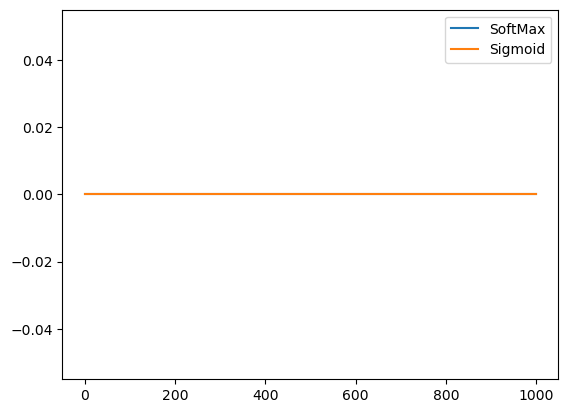

SoftMax last cost = 0.0
Sigmoid last cost = 0.0


In [22]:
network_SoftMax, network_Sigmoid = present([2, 5, 2], x_X_train, one_hot(x_y_train), 1000, 0.001, 0.1, True)

train F-score = 0.49853773603828766
test F-score  = 0.4927773497688751


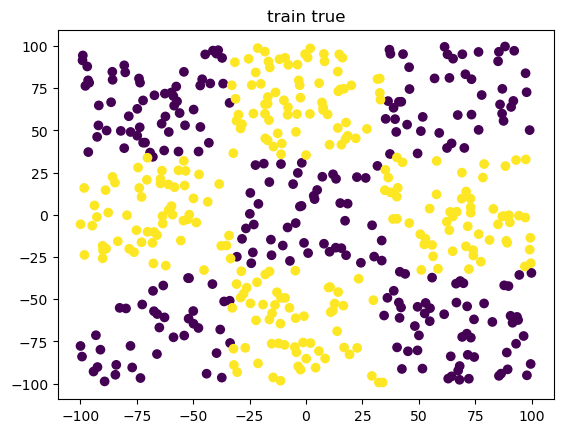

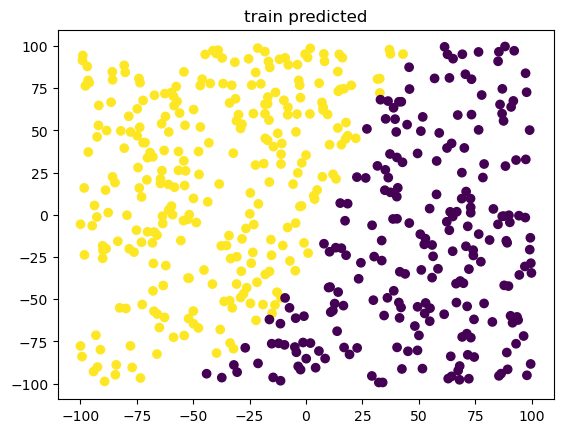

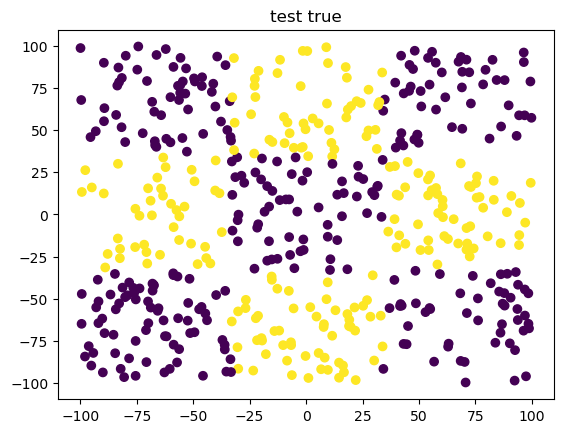

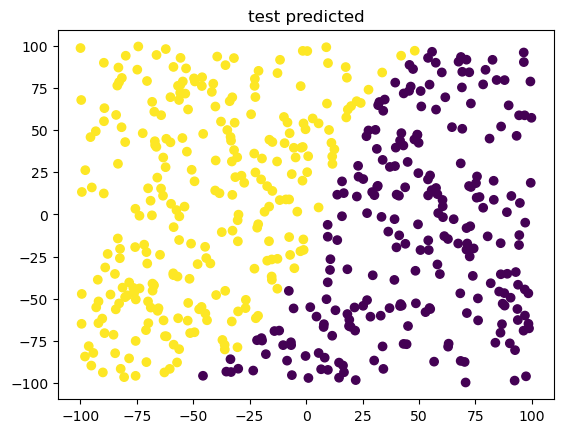

In [23]:
plot_predict(network_SoftMax, x_X_train, x_y_train, x_X_test, x_y_test)

train F-score = 0.4995495946351717
test F-score  = 0.49392353090060304


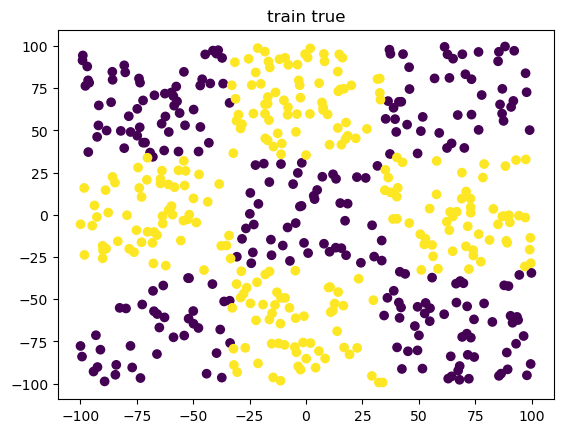

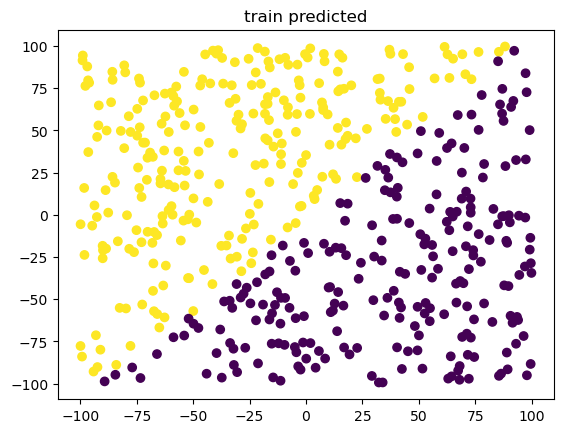

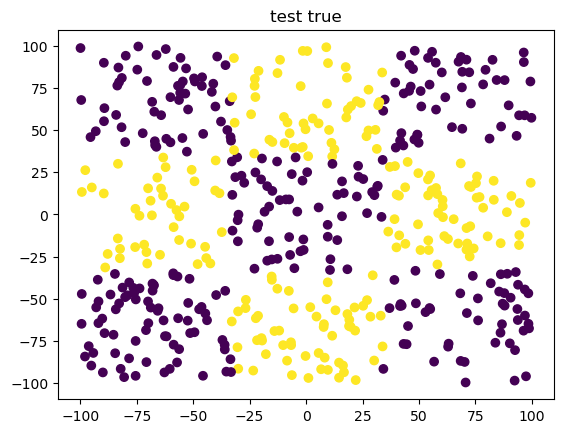

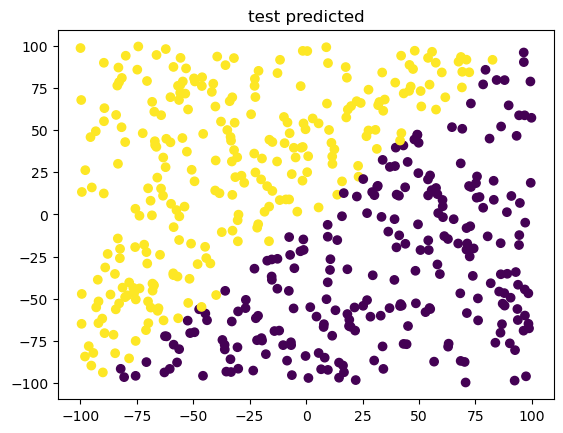

In [24]:
plot_predict(network_Sigmoid, x_X_train, x_y_train, x_X_test, x_y_test)